# Second Level 

In [1]:
import pandas as pd
import numpy as np 
import gc

### Load first level data 

In [60]:
with pd.HDFStore('../data/feat/stage2_data.h5') as stage2_h5:
    print(stage2_h5.keys())
    stage2_df = stage2_h5['stage2_df']

['/stage2_df']


In [61]:
stage2_df.head()

,rg,lasso,rf,lgbm,kmean_dist_label,kmean_dist_0,kmean_dist_1,kmean_dist_2,kmean_dist_3,kmean_dist_4,kmean_dist_5,kmean_dist_6,kmean_dist_7
0,0.457809,0.518210,1.104751,1.234071,1.0,8.857702,8.712146,6.878428,7.236687,160.683082,8.372746,10.067307,32.780615
1,0.990932,0.951176,1.786170,2.333394,5.0,12.806890,13.463366,11.329752,7.886795,162.224312,10.882863,14.441723,33.894320
2,0.473575,0.448425,0.640284,0.663168,5.0,9.285941,10.126022,8.115691,6.480298,161.687453,7.767159,11.381747,32.819151
3,0.421733,0.397657,0.457851,0.487791,6.0,8.528922,8.592862,6.444938,6.349900,161.312547,7.830429,9.995115,32.689497
4,0.406524,0.390211,0.397525,0.391166,6.0,8.568154,8.632067,6.464528,6.335744,161.346125,7.866945,10.024922,32.699838


### Load features 

In [4]:
with pd.HDFStore('../data/feat/data.h5') as store:
    print(store.keys())
    X_cv = store['X_cv']
    X_train = store['X_train']
    X_test = store['X_test']
    y_cv = store['y_cv']
    y_train = store['y_train']

['/X_cv', '/X_test', '/X_train', '/y_cv', '/y_train']


In [5]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [6]:
X_train = downcast_dtypes(X_train)
X_cv = downcast_dtypes(X_cv)
X_test = downcast_dtypes(X_test)

y_train = y_train.astype(np.float32)
y_cv = y_cv.astype(np.float32)

gc.collect()


26

In [7]:
X_train.fillna(0,inplace=True)
X_cv.fillna(0,inplace=True)
X_test.fillna(0,inplace=True)

In [8]:
y_train = y_train.clip(0,20)
y_cv = y_cv.clip(0,20)

## Reduce training size


In [9]:
train_dates = X_train.date_block_num

mask = train_dates >= 12 ## >=12 
X_train = X_train[mask] # [-32]
y_train = y_train[mask] # [-32]

# level2_date_block = [27, 28, 29, 30, 31, 32]
level2_date_block = [31, 32]
level2_mask = train_dates.isin(level2_date_block) ## [0-32]
train_dates_level2 = train_dates[level2_mask] ## [27-32]
train_y_level2 = y_train[level2_mask] # [27-32]

train_dates = train_dates[mask] ## -32
test_dates = X_test.date_block_num ## 34
cv_dates = X_cv.date_block_num ## 33

merge = pd.concat([X_train, X_cv, X_test], ignore_index=True) ## 0-34
merge_dates = np.concatenate([train_dates,cv_dates, test_dates], axis=0)  ## 0-34
merge_y = np.concatenate([y_train,y_cv, np.zeros((len(test_dates),))], axis=0) ## y 0-34

In [10]:
stage2_train_dates = merge_dates[merge_dates>=level2_date_block[0]] ## 27 - 34
stage2_train_mask = (stage2_train_dates <= level2_date_block[-1]) # train on : 27-32
stage2_valid_mask = (stage2_train_dates == 33) ## validate on : 33
stage2_final_train_mask = (stage2_train_dates <= 33) ## 27-33
stage2_test_mask = (stage2_train_dates==34) ## 34 want to predict and submit 
stage2_train_y = merge_y[merge_dates>=level2_date_block[0]] ## 27-34

In [13]:
print('train======\n',pd.Series(stage2_train_mask).value_counts()) ## 27-32
print('validate======\n',pd.Series(stage2_valid_mask).value_counts()) ## 33
print('final=======\n',pd.Series(stage2_final_train_mask).value_counts())
print('test=======\n',pd.Series(stage2_test_mask).value_counts())

train======
 False    452372
True     433191
dtype: int64
validate======
 False    647391
True     238172
dtype: int64
final=======
 True     671363
False    214200
dtype: int64
test=======
 False    671363
True     214200
dtype: int64


### 1st level rg text features

In [62]:
stage2_data_text = np.load('../data/feat/stage2_data_text.npy')

In [65]:
stage2_data_text.shape

(1828564,)

In [64]:
stage2_df.loc[:,'rg_text'] = stage2_data_text

ValueError: Length of values does not match length of index

In [71]:
stage2_df.tail()

,rg,lasso,rf,lgbm,kmean_dist_label,kmean_dist_0,kmean_dist_1,kmean_dist_2,kmean_dist_3,kmean_dist_4,kmean_dist_5,kmean_dist_6,kmean_dist_7,rg_text
885558,0.134964,0.125358,0.097561,0.107874,5.0,9.626541,10.444644,8.157898,5.956461,161.739534,8.003142,11.677549,32.903983,NaN
885559,0.139166,0.142591,0.024059,0.043879,5.0,12.879920,13.537854,11.259585,7.745059,162.398219,10.970714,14.512317,33.926956,NaN
885560,0.030850,0.045098,0.035809,0.033042,1.0,8.889758,8.961213,6.481952,5.770090,161.455787,8.039186,10.330557,32.773890,NaN
885561,0.135251,0.125836,0.027331,0.024500,0.0,9.597628,10.414772,8.158585,6.004372,161.741704,7.981184,11.652426,32.893805,NaN
885562,0.184883,0.174133,0.038164,0.026015,1.0,8.796314,8.847850,6.483378,5.891997,161.397045,7.952752,10.240780,32.746163,NaN


______

In [72]:
model_cols = ['rg','lasso','rf','lgbm']
used_cols = ['rg','lasso','rf','lgbm','kmean_dist_label']
stage2_df = stage2_df[used_cols]
stage2_df[model_cols].corr()

,rg,lasso,rf,lgbm
rg,1.000000,0.991632,0.753673,0.724303
lasso,0.991632,1.000000,0.764889,0.737370
rf,0.753673,0.764889,1.000000,0.973793
lgbm,0.724303,0.737370,0.973793,1.000000


In [17]:
import matplotlib.pyplot as plt
%matplotlib inline 

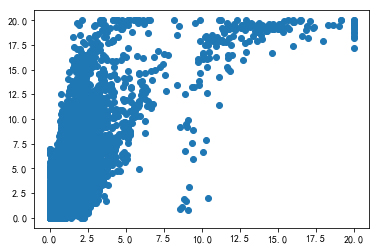

In [73]:
plt.scatter(stage2_df.lasso, stage2_df.lgbm)

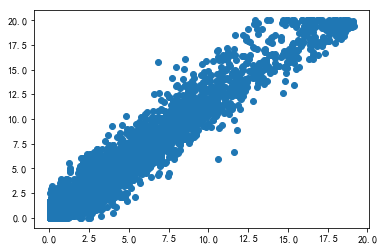

In [19]:
plt.scatter(stage2_df.rf, stage2_df.lgbm)

In [16]:
stage2_df[['rf','rg']].head()

,rf,rg
0,1.104751,0.457809
1,1.786170,0.990932
2,0.640284,0.473575
3,0.457851,0.421733
4,0.397525,0.406524


In [45]:
from scipy.stats.mstats import hmean, gmean

In [46]:
def stage2_feat_engineer(df, model_cols=[]):
    model_cnt = df[model_cols].shape[1]
    
    print('Calculating 2 g\\h\\m-mean')
    for i in range(model_cnt-1): # i = 0 to model_cnt-2
        for j in range(i+1, model_cnt): # j = i+1 to model_cnt-1
            cols = [model_cols[i], model_cols[j]]
            df.loc[:, 'gmean_' + str(i) + '_'+ str(j)] = gmean(df.loc[:,cols].values, axis=1)
            df.loc[:, 'mean_' + str(i) + '_'+ str(j)] = np.mean(df.loc[:,cols].values, axis=1)

    if model_cnt > 3:
        print('Calculating 3 g\\h\\m-mean')        
        for i in range(model_cnt-2): # i = 0 to model_cnt-3
            for j in range(i+1, model_cnt-1): # j = i+1 to model_cnt-2
                for k in range(j+1, model_cnt): # k = j+1 to model_cnt-1
                    cols = [model_cols[i], model_cols[j], model_cols[k]]
                    df.loc[:, 'gmean_' + str(i) + '_'+ str(j) + '_'+ str(k)] = gmean(df.loc[:,cols].values, axis=1)
                    df.loc[:, 'mean_' + str(i) + '_'+ str(j) + '_'+ str(k)] = np.mean(df.loc[:,cols].values, axis=1)

    print('Calculating all g\\h\\m-mean')             
    df.loc[:, 'gmean_all'] = gmean(df.loc[:,model_cols].values, axis=1)
    df.loc[:, 'mean'] = np.mean(df.loc[:,model_cols].values, axis=1)
    df.loc[:, 'med'] = np.median(df.loc[:,model_cols].values, axis=1)
    df.loc[:, 'max'] = np.amax(df.loc[:,model_cols].values, axis=1)
    df.loc[:, 'min'] = np.amin(df.loc[:,model_cols].values, axis=1)
    df.loc[:, 'std'] = np.std(df.loc[:,model_cols].values, axis=1)

In [74]:
model_cols

['rg', 'lasso', 'rf', 'lgbm']

In [48]:
stage2_feat_engineer(stage2_df,['rf','lgbm'])

Calculating 2 g\h\m-mean


C:\Program Files\Anaconda3\envs\py36\lib\site-packages\scipy\stats\stats.py:314: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
C:\Program Files\Anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Program Files\Anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Calculating all g\h\m-mean


In [75]:
stage2_df.columns

Index(['rg', 'lasso', 'rf', 'lgbm', 'kmean_dist_label'], dtype='object')

In [76]:
stage2_df = downcast_dtypes(stage2_df)

In [77]:
gc.collect()

14

In [78]:
stage2_df.shape

(885563, 5)

In [79]:
stage2_df = pd.concat([stage2_df, merge[merge_dates>=level2_date_block[0]].reset_index(drop=True)], axis=1)

# Train on 2nd Level 
- train on `27-32` ,`stage2_train_mask`  
- validate on `33`
- final train on `27-33` and predict on `34`

In [81]:
pd.Series(stage2_train_mask).value_counts()

False    452372
True     433191
dtype: int64

In [82]:
pd.Series(stage2_valid_mask).value_counts()

False    647391
True     238172
dtype: int64

In [83]:
# stage2_df[stage2_train_mask]
stage2_df[stage2_valid_mask].shape

(238172, 59)

In [84]:
pd.Series(stage2_final_train_mask).value_counts()

True     671363
False    214200
dtype: int64

In [85]:
import lightgbm as lgb
import copy 
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error

In [86]:
def objective(params):
    
    clf = params.get('clf')
    new_params = params.get('params') ## update params


    copy_clf = copy.deepcopy(clf)
    original_params = copy_clf.get_params()
    original_params.update(new_params)
    copy_clf.set_params(**original_params) # update copy clf with trying new_params              
    
    ## simple hold out 
    
    copy_clf.fit(stage2_df[stage2_train_mask].values, stage2_train_y[stage2_train_mask]) ### fit on [27-32]
    
    pred_y = copy_clf.predict(stage2_df[stage2_valid_mask].values) ## validate on 33
    pred_y = np.clip(pred_y, 0., 20.) # clip to (0,20)
    rmse = mean_squared_error(stage2_train_y[stage2_valid_mask], pred_y)**.5 
    print('rmse: {:.5f} '.format(rmse), end='\t')
    print('params: {}'.format(new_params))
    
    return {'loss':rmse,'status':STATUS_OK}

In [35]:
# stage2_df = stage2_df[['rf','lgbm','kmean_dist_label']]
# stage2_df[stage2_valid_mask].head()

In [87]:
y_val = stage2_train_y[stage2_valid_mask] ##33
stage2_val_df = stage2_df[stage2_valid_mask]

In [30]:
# stage2_val_df.reset_index(inplace=True,drop=True)
# df_val = pd.DataFrame({'y':y_val})
# pd.concat((stage2_val_df,df_val),axis=1).head().T

,0,1,2,3,4
rg,0.206704,0.251394,0.181789,0.093240,0.337916
lasso,0.210538,0.261407,0.196857,0.125308,0.358665
rf,0.032139,0.797239,0.498579,0.134226,0.776439
lgbm,0.046392,0.776989,0.533678,0.139150,0.596890
kmean_dist_label,5.000000,1.000000,1.000000,0.000000,1.000000
y,1.000000,1.000000,2.000000,1.000000,1.000000


In [90]:
''' simple test on params tuning for validation data (33)'''

params = {    
    'boosting_type': 'dart',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 30,
    'learning_rate': 0.2
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5    
}

lgb_train = lgb.Dataset(stage2_df[stage2_train_mask].values, stage2_train_y[stage2_train_mask])
lgb_cv = lgb.Dataset(stage2_df[stage2_valid_mask].values, stage2_train_y[stage2_valid_mask], reference=lgb_train)

reg = lgb.train(params,
                early_stopping_rounds = 5,
                train_set = lgb_train,
                valid_sets=lgb_cv,
                verbose_eval = True)

[1]	valid_0's rmse: 1.0631
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 1.02976
[3]	valid_0's rmse: 1.01606
[4]	valid_0's rmse: 1.01916
[5]	valid_0's rmse: 1.02526
[6]	valid_0's rmse: 1.04104
[7]	valid_0's rmse: 1.04637
[8]	valid_0's rmse: 1.03466
Early stopping, best iteration is:
[3]	valid_0's rmse: 1.01606


In [91]:
lgb_clf = lgb.LGBMRegressor(random_state=0, n_jobs=4)

# 1. find an optimal n_esti for rather larger learning rate
lgb_params = {
    'clf' : lgb_clf,
    'params': {
        
#         'boosting_type': hp.choice('boosting_type',['gbdt', 'dart']), ## dart
        'boosting_type': 'dart',
        'max_depth' : hp.choice("max_depth", np.arange(2, 20, dtype=int)),    
        'num_leaves'   : hp.choice('num_leaves', np.arange(8,129,2,dtype=int)),        
        
        'feature_fraction': hp.uniform('feature_fraction', 0.3, 1.0),
        'bagging_fraction': hp.uniform ('bagging_fraction', 0.7, 1),
        'reg_alpha' : hp.uniform('reg_alpha',0,1),
        'reg_lambda': hp.uniform('reg_lambda',0,1),
        'gamma' : hp.uniform('gamma', 0.1,0.5)
    }
    
}
best =fmin(fn = objective,
           space = lgb_params,
           algo = tpe.suggest,
           max_evals = 10
           )

rmse: 1.02125 	params: {'bagging_fraction': 0.7240793763551191, 'boosting_type': 'dart', 'feature_fraction': 0.6830912900703034, 'gamma': 0.488617504629549, 'max_depth': 18, 'num_leaves': 90, 'reg_alpha': 0.9903917796656031, 'reg_lambda': 0.8443421903688777}
rmse: 0.99749 	params: {'bagging_fraction': 0.9938987643433466, 'boosting_type': 'dart', 'feature_fraction': 0.869316061000057, 'gamma': 0.14827457797523502, 'max_depth': 6, 'num_leaves': 12, 'reg_alpha': 0.8378206313981945, 'reg_lambda': 0.6750077058017657}
rmse: 1.05568 	params: {'bagging_fraction': 0.8422155826160889, 'boosting_type': 'dart', 'feature_fraction': 0.8687919615038129, 'gamma': 0.20229886306058942, 'max_depth': 15, 'num_leaves': 110, 'reg_alpha': 0.9221163621809578, 'reg_lambda': 0.7842848348863404}


KeyboardInterrupt: 

In [36]:
best

{'bagging_fraction': 0.7682846887438464,
 'boosting_type': 1,
 'feature_fraction': 0.5753991342264869,
 'gamma': 0.27914831744734536,
 'max_depth': 1,
 'num_leaves': 16,
 'reg_alpha': 0.5590666758177603,
 'reg_lambda': 0.8430454690248188}

In [166]:
lgb_clf = lgb.LGBMRegressor(random_state=0, n_jobs=8)
lgb_params = {
    'clf' : lgb_clf,
    'params': {
        
        'boosting_type': 'dart',
        'max_depth' : 10, 
        'num_leaves'   : 13,         
        'feature_fraction': 0.7703258965795443,
        'bagging_fraction': 0.834750265236025,
        'reg_alpha' : 0.45107691031250763,
        'reg_lambda': 0.8878342456557001,
        'gamma' : 0.4687491515287674
    }    
}
best_lgb_2nd_val_loss = objective(lgb_params)

rmse: 0.91792 	params: {'boosting_type': 'dart', 'max_depth': 10, 'num_leaves': 13, 'feature_fraction': 0.7703258965795443, 'bagging_fraction': 0.834750265236025, 'reg_alpha': 0.45107691031250763, 'reg_lambda': 0.8878342456557001, 'gamma': 0.4687491515287674}


> rmse: 0.91882 	
- params: `{'bagging_fraction': 0.8219608927918671, 'boosting_type': 'dart', 'feature_fraction': 0.8197533685642909, 'gamma': 0.4386326407529417, 'max_depth': 11, 'num_leaves': 10, 'reg_alpha': 0.7227955651016644, 'reg_lambda': 0.11999749478454569}`

# Submission

In [149]:
# lgb_train = lgb.Dataset(stage2_df[stage2_final_train_mask],stage2_train_y[stage2_final_train_mask])
# params_best = {
#         'boosting_type': 'dart',
#         'max_depth' : 11,
#         'num_leaves': 10,        
#         'feature_fraction': 0.81975,
#         'bagging_fraction': 0.82196,
#         'reg_alpha' : 0.7228,
#         'reg_lambda': 0.1200,
#         'gamma' : 0.4386
# }
# # lgb_cv = lgb.Dataset(X_cv,y_cv,reference=lgb_train)
# reg_sub = lgb.train(params_best,                    
#                     train_set = lgb_train
#                     )

In [168]:
lgb_params = {                
    'boosting_type': 'dart',
    'max_depth' : 10, 
    'num_leaves'   : 13,         
    'feature_fraction': 0.7703258965795443,
    'bagging_fraction': 0.834750265236025,
    'reg_alpha' : 0.45107691031250763,
    'reg_lambda': 0.8878342456557001,
    'gamma' : 0.4687491515287674
}

In [170]:
lgb_clf = lgb.LGBMRegressor(random_state=0, n_jobs=8,**lgb_params)

## simple hold out 

lgb_clf.fit(stage2_df[stage2_train_mask].values, stage2_train_y[stage2_train_mask])    

pred_y = lgb_clf.predict(stage2_df[stage2_valid_mask].values)
pred_y = np.clip(pred_y, 0., 20.) # clip to (0,20)
rmse = mean_squared_error(stage2_train_y[stage2_valid_mask], pred_y)**.5
print('rmse: {:.5f} '.format(rmse), end='\t')


rmse: 0.91792 	

In [1]:
lgb_clf = lgb.LGBMRegressor(random_state=0, n_jobs=8,**lgb_params)
lgb_clf.fit(stage2_df[stage2_final_train_mask].values,stage2_train_y[stage2_final_train_mask])
pred_y = lgb_clf.predict(stage2_df[stage2_test_mask].values)
pred_y = np.clip(pred_y,0,20)
## 

NameError: name 'lgb' is not defined

In [172]:
y_submit = pd.DataFrame({'ID':range(len(pred_y)), 'item_cnt_month':pred_y}) # validate on 2015oct : 0.91732, LB: 0.94824
y_submit.to_csv('../data/output/submission_lgbm5_stacking_finetune_params.csv',index=False) # stacking